In [1]:
import torch
import torchvision
import os
import glob
import time 
import pickle

#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

from src.data import LungDataset, blend, Pad, Crop, Resize
from src.models import UNet, PretrainedUNet
from src.metrics import jaccard, dice

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
data_folder = Path("input", "dataset")
origins_folder = data_folder / "images"
masks_folder = data_folder / "masks"
models_folder = Path("models")
images_folder = Path("images")

In [4]:
batch_size = 4

## Data loading

In [5]:
origins_list = [f.stem for f in origins_folder.glob("*.png")]
masks_list = [f.stem for f in masks_folder.glob("*.png")]

In [6]:
print(len(origins_list))
print(len(masks_list))

800
704


In [7]:
origin_mask_list = [(mask_name.replace("_mask", ""), mask_name) for mask_name in masks_list]

In [8]:
split_file = "splits.pk"
if os.path.isfile(split_file):
    with open("splits.pk", "rb") as f:
        splits = pickle.load(f)
else:
    splits = {}
    splits["train"], splits["test"] = train_test_split(origin_mask_list, test_size=0.2, random_state=42)
    splits["train"], splits["val"] = train_test_split(splits["train"], test_size=0.1, random_state=42)

    with open("splits.pk", "wb") as f:
        pickle.dump(splits, f)

In [9]:
val_test_transforms = torchvision.transforms.Compose([
    Resize((512, 512)),
])

train_transforms = torchvision.transforms.Compose([
    Pad(200),
    Crop(300),
    val_test_transforms,
])

datasets = {x: LungDataset(
    splits[x], 
    origins_folder, 
    masks_folder, 
    train_transforms if x == "train" else val_test_transforms
) for x in ["train", "test", "val"]}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size) for x in ["train", "test", "val"]}

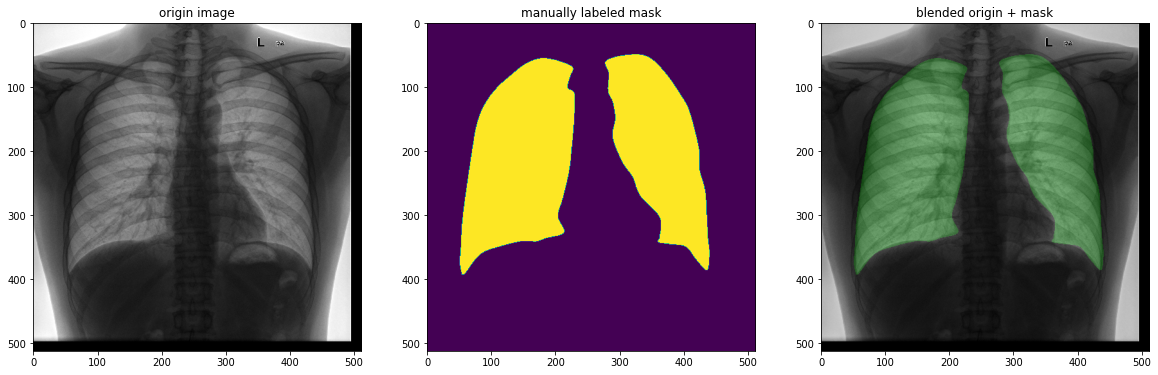

In [10]:
idx = 0
phase = "train"

plt.figure(figsize=(20, 10))
origin, mask = datasets[phase][idx]
pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")
pil_mask = torchvision.transforms.functional.to_pil_image(mask.float())

plt.subplot(1, 3, 1)
plt.title("origin image")
plt.imshow(np.array(pil_origin))

plt.subplot(1, 3, 2)
plt.title("manually labeled mask")
plt.imshow(np.array(pil_mask))

plt.subplot(1, 3, 3)
plt.title("blended origin + mask")
plt.imshow(np.array(blend(origin, mask)));

plt.savefig(images_folder / "data-example.png", bbox_inches='tight')

## Model training

In [11]:
# unet = UNet(in_channels=1, out_channels=2, batch_norm=True)
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)
unet

PretrainedUNet(
  (init_conv): Conv2d(1, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [12]:
unet = unet.to(device)
# optimizer = torch.optim.SGD(unet.parameters(), lr=0.0005, momentum=0.9)
optimizer = torch.optim.Adam(unet.parameters(), lr=0.0005)

In [13]:
train_log_filename = "train-log.txt"
epochs = 30
best_val_loss = np.inf
model_name = "unet-6v.pt"

In [14]:
hist = []

for e in range(epochs):
    start_t = time.time()
    
    print("train phase")
    unet.train()
    train_loss = 0.0
    for origins, masks in dataloaders["train"]:
        num = origins.size(0)
        
        origins = origins.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        loss = torch.nn.functional.nll_loss(softmax, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * num
        print(".", end="")
        
    train_loss = train_loss / len(datasets['train'])
    print()
    
    
    print("validation phase")
    unet.eval()
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0

    for origins, masks in dataloaders["val"]:
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            outs = unet(origins)
            softmax = torch.nn.functional.log_softmax(outs, dim=1)
            val_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

            outs = torch.argmax(softmax, dim=1)
            outs = outs.float()
            masks = masks.float()
            val_jaccard += jaccard(masks, outs.float()).item() * num
            val_dice += dice(masks, outs).item() * num

        print(".", end="")
    val_loss = val_loss / len(datasets["val"])
    val_jaccard = val_jaccard / len(datasets["val"])
    val_dice = val_dice / len(datasets["val"])
    print()
    
    
    end_t = time.time()
    spended_t = end_t - start_t
    
    with open(train_log_filename, "a") as train_log_file:
        report = f"epoch: {e+1}/{epochs}, time: {spended_t}, train loss: {train_loss}, \n"\
               + f"val loss: {val_loss}, val jaccard: {val_jaccard}, val dice: {val_dice}"

        hist.append({
            "time": spended_t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_jaccard": val_jaccard,
            "val_dice": val_dice,
        })

        print(report)
        train_log_file.write(report + "\n")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(unet.state_dict(), models_folder / model_name)
            print("model saved")
            train_log_file.write("model saved\n")
        print()
        

train phase


/home/azureuser/.local/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


...............................................................................................................................
validation phase
...............
epoch: 1/30, time: 621.3617033958435, train loss: 0.27156852545003174, 
val loss: 0.19335492739551946, val jaccard: 0.8690360366252431, val dice: 0.9215837602029767
model saved

train phase
...............................................................................................................................
validation phase
...............
epoch: 2/30, time: 622.2720282077789, train loss: 0.15956670092970957, 
val loss: 0.16625399652280307, val jaccard: 0.8697195690974855, val dice: 0.9207860712419477
model saved

train phase
...............................................................................................................................
validation phase
...............
epoch: 3/30, time: 622.9199860095978, train loss: 0.12572833936911798, 
val loss: 0.1433963299843303, val jaccard: 0.8716901227047569, va

epochs: 30, overall time: 312.0m, mean epoch time: 624.922762521108s


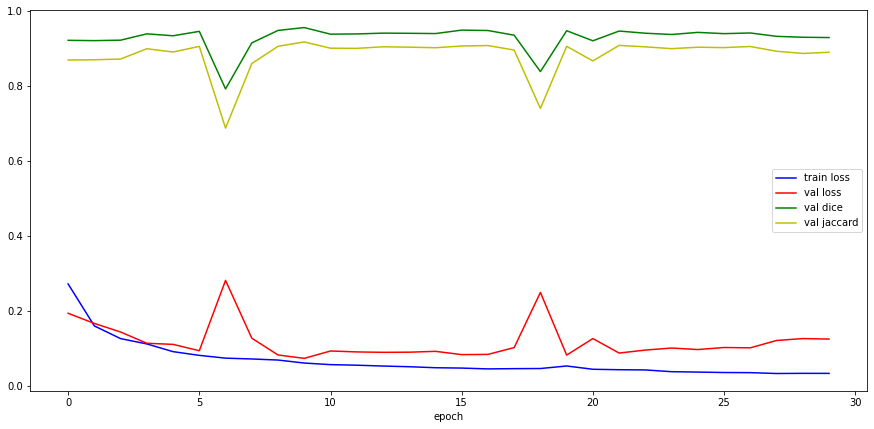

In [15]:
plt.figure(figsize=(15,7))
train_loss_hist = [h["train_loss"] for h in hist]
plt.plot(range(len(hist)), train_loss_hist, "b", label="train loss")

val_loss_hist = [h["val_loss"] for h in hist]
plt.plot(range(len(hist)), val_loss_hist, "r", label="val loss")

val_dice_hist = [h["val_dice"] for h in hist]
plt.plot(range(len(hist)), val_dice_hist, "g", label="val dice")

val_jaccard_hist = [h["val_jaccard"] for h in hist]
plt.plot(range(len(hist)), val_jaccard_hist, "y", label="val jaccard")

plt.legend()
plt.xlabel("epoch")
plt.savefig(images_folder / model_name.replace(".pt", "-train-hist.png"))

time_hist = [h["time"] for h in hist]
overall_time = sum(time_hist) // 60
mean_epoch_time = sum(time_hist) / len(hist)
print(f"epochs: {len(hist)}, overall time: {overall_time}m, mean epoch time: {mean_epoch_time}s")

In [16]:
torch.cuda.empty_cache()

## Evaluate

In [17]:
unet = PretrainedUNet(1, 2, True, "bilinear")

In [18]:
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [19]:
test_loss = 0.0
test_jaccard = 0.0
test_dice = 0.0

for origins, masks in dataloaders["test"]:
    num = origins.size(0)

    origins = origins.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        test_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

        outs = torch.argmax(softmax, dim=1)
        outs = outs.float()
        masks = masks.float()
        test_jaccard += jaccard(masks, outs).item() * num
        test_dice += dice(masks, outs).item() * num
    print(".", end="")

test_loss = test_loss / len(datasets["test"])
test_jaccard = test_jaccard / len(datasets["test"])
test_dice = test_dice / len(datasets["test"])

print()
print(f"avg test loss: {test_loss}")
print(f"avg test jaccard: {test_jaccard}")
print(f"avg test dice: {test_dice}")

....................................
avg test loss: 0.0643947681953721
avg test jaccard: 0.9244258648960303
avg test dice: 0.9597703366414875


.........
red area - predict
green area - ground truth
yellow area - intersection


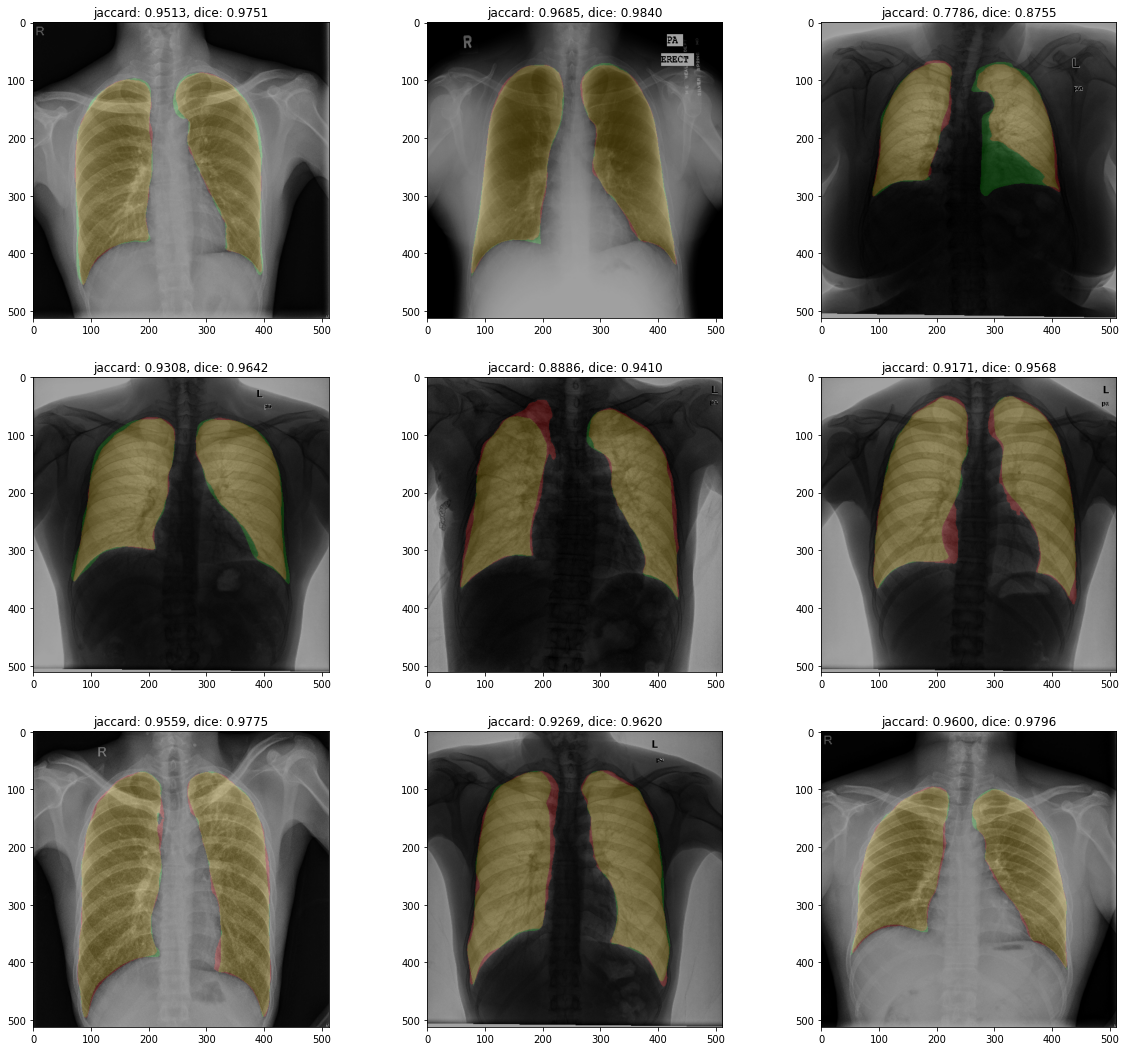

In [20]:
num_samples = 9
phase = "test"

subset = torch.utils.data.Subset(
    datasets[phase], 
    np.random.randint(0, len(datasets[phase]), num_samples)
)
random_samples_loader = torch.utils.data.DataLoader(subset, batch_size=1)
plt.figure(figsize=(20, 25))

for idx, (origin, mask) in enumerate(random_samples_loader):
    plt.subplot((num_samples // 3) + 1, 3, idx+1)

    origin = origin.to(device)
    mask = mask.to(device)

    with torch.no_grad():
        out = unet(origin)
        softmax = torch.nn.functional.log_softmax(out, dim=1)
        out = torch.argmax(softmax, dim=1)

        jaccard_score = jaccard(mask.float(), out.float()).item()
        dice_score = dice(mask.float(), out.float()).item()

        origin = origin[0].to("cpu")
        out = out[0].to("cpu")
        mask = mask[0].to("cpu")

        plt.imshow(np.array(blend(origin, mask, out)))
        plt.title(f"jaccard: {jaccard_score:.4f}, dice: {dice_score:.4f}")
        print(".", end="")
            
plt.savefig(images_folder / "obtained-results.png", bbox_inches='tight')
print()         
print("red area - predict")
print("green area - ground truth")
print("yellow area - intersection")

## Inference


In [21]:
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)

In [22]:
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [23]:
device

device(type='cuda', index=0)

In [24]:
origin_filename = "input/dataset/images/CHNCXR_0042_0.png"

In [25]:
origin = Image.open(origin_filename).convert("P")
origin = torchvision.transforms.functional.resize(origin, (512, 512))
origin = torchvision.transforms.functional.to_tensor(origin) - 0.5

In [26]:
with torch.no_grad():
    origin = torch.stack([origin])
    origin = origin.to(device)
    out = unet(origin)
    softmax = torch.nn.functional.log_softmax(out, dim=1)
    out = torch.argmax(softmax, dim=1)
    
    origin = origin[0].to("cpu")
    out = out[0].to("cpu")

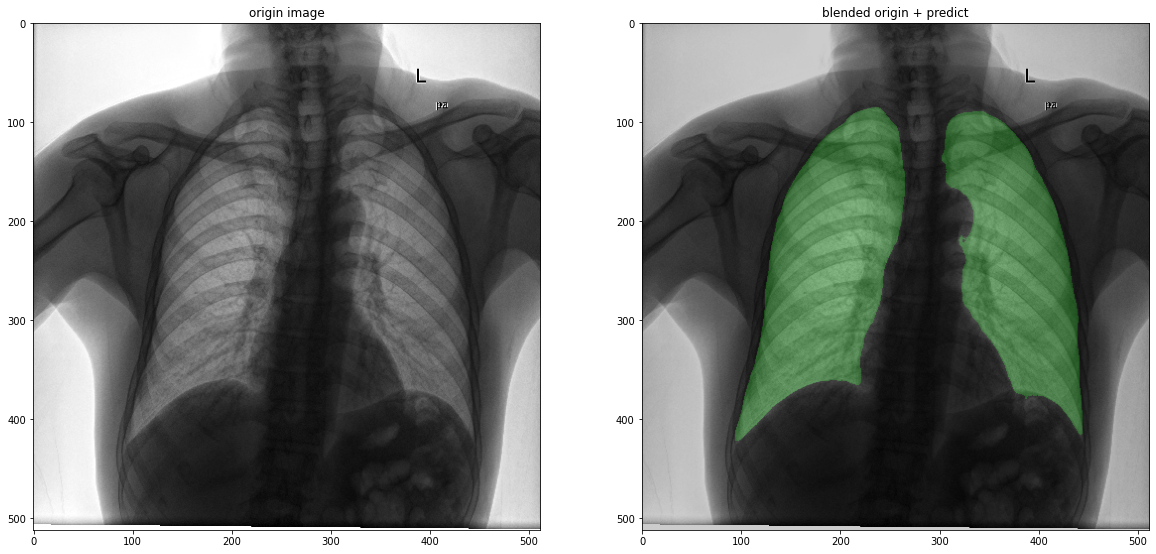

In [27]:
plt.figure(figsize=(20, 10))

pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")

plt.subplot(1, 2, 1)
plt.title("origin image")
plt.imshow(np.array(pil_origin))

plt.subplot(1, 2, 2)
plt.title("blended origin + predict")
plt.imshow(np.array(blend(origin, out)));